In [1]:

# ============================================================
# NOTEBOOK EN TEXTO — ML Riesgo de Incendio
# Preparado para Google Colab
# ============================================================
#
# INSTRUCCIONES RÁPIDAS (LEER ESTO DENTRO DEL CÓDIGO):
# - Ajusta FILEPATH (arriba) según si el CSV está subido a /content/ o en Drive.
# - Este script:
#   1) Monta Drive (obligatorio)
#   2) Carga CSV + QA (chequeos de rangos)
#   3) Parsea .geo -> lon/lat
#   4) Prepara dataset + split estratificado
#   5) Maneja desbalance (class_weight + oversampling opcional automático)
#   6) Entrena y evalúa Logistic Regression y RandomForest
#   7) Elige mejor modelo priorizando recall y PR-AUC (muy importante en desbalance)
#   8) Guarda artefactos en Drive
#   9) Predice sobre todo el dataset y exporta CSV + GeoJSON (QGIS)
#
#
# ============================================================


# ============================================================
# 0) (Colab) Instalación / Imports / Reproducibilidad
# ============================================================
# En este script:
# - scikit-learn: modelos (LogisticRegression, RandomForest), métricas, pipelines
# - pandas/numpy: manejo de datos tabulares
# - matplotlib: gráficas (ROC y Precision-Recall)
# - joblib/json/os: guardar modelos y resultados
# - imbalanced-learn (opcional): oversampling (solo si hay desbalance fuerte)
#
# Reproducibilidad (random_state)
# ------------------------------
# Muchos algoritmos (y el split train/test) tienen "azar" interno.
# Si fijas random_state, obtienes SIEMPRE el mismo resultado para el mismo dataset.
#
# Mini-ejemplo mental:
#   - Sin random_state:
#       train_test_split(...) te parte el dataset distinto cada vez -> métricas cambian
#   - Con random_state=42:
#       el split es el mismo -> métricas comparables
#
# Nota: reproducibilidad ≠ "verdad absoluta". Solo significa consistencia.
# ============================================================

# --- (Opcional) Asegurar librerías ---
# En Colab normalmente ya vienen pandas/numpy/sklearn/matplotlib.
# imbalanced-learn puede no venir. Lo instalamos SOLO si hace falta más adelante.

import os
import json
import math
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

import joblib

warnings.filterwarnings("ignore")

# --- Reproducibilidad global (numpy) ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ [0] Imports OK")
print("✅ [0] RANDOM_STATE =", RANDOM_STATE)

✅ [0] Imports OK
✅ [0] RANDOM_STATE = 42


In [2]:

# ============================================================
# 1) (Colab) Montar Google Drive + Cargar archivo (Upload o Drive)
# ============================================================
# Drive.mount('/content/drive') (OBLIGATORIO)
# -----------------------------------------
# ARTIFACT_DIR está dentro de Drive:
#   /content/drive/MyDrive/Piloto-Incendios/03-Artefactos
#
#
# IMPORTANTE:
# - Usaremos FILEPATH para elegir ruta (fácil de cambiar).
# ============================================================

# --- Carpeta de artefactos (OBLIGATORIA) ---
ARTIFACT_DIR = "/content/drive/MyDrive/Piloto-Incendios/03-Artefactos"

# --- Rutas típicas del CSV (según tu contexto) ---
FILEPATH_COLAB_UPLOAD = "/content/samples_el_bierzo_2020_250m.csv"
FILEPATH_DRIVE = "/content/drive/MyDrive/Piloto-Incendios/samples_el_bierzo_2020_250m.csv"

# >>> CAMBIA ESTA VARIABLE SI HACE FALTA <<<
FILEPATH = FILEPATH_DRIVE   # <- opción recomendada si ya está en Drive
# FILEPATH = FILEPATH_COLAB_UPLOAD  # <- si lo subes manualmente a /content/

def _is_colab() -> bool:
    """Detecta si estamos en Google Colab."""
    try:
        import google.colab  # noqa: F401
        return True
    except Exception:
        return False

# --- Montar Drive ---
if _is_colab():
    from google.colab import drive
    print("\n🔧 [1] Montando Google Drive (obligatorio)...")
    drive.mount("/content/drive")
    print("✅ [1] Drive montado en /content/drive")
else:
    print("\nℹ️ [1] No estás en Colab (detectado). Intentaré continuar igualmente.")
    print("   Pero OJO: ARTIFACT_DIR apunta a /content/drive/... y puede no existir aquí.")

# --- (Opcional) Upload manual ---
# Si FILEPATH apunta a /content/... y el archivo NO existe, te damos la opción de subirlo.
if _is_colab() and (FILEPATH == FILEPATH_COLAB_UPLOAD) and (not os.path.isfile(FILEPATH)):
    print("\n📤 [1] No encuentro el CSV en /content/. Vamos a subirlo (upload manual).")
    print("   - Se abrirá un selector de archivos.")
    print("   - Elige tu CSV y Colab lo subirá a /content/")
    from google.colab import files
    uploaded = files.upload()  # el usuario elige el archivo
    # Si el usuario sube un archivo con otro nombre, tomamos el primero:
    if len(uploaded) > 0:
        first_name = list(uploaded.keys())[0]
        # Si el nombre subido no coincide con el esperado, lo renombramos para mantener consistencia:
        if first_name != os.path.basename(FILEPATH):
            os.rename(first_name, os.path.basename(FILEPATH))
        print("✅ [1] Upload completado:", FILEPATH)
    else:
        print("⚠️ [1] No se subió ningún archivo. Revisa el upload y vuelve a ejecutar.")
else:
    print("\n📌 [1] FILEPATH configurado como:", FILEPATH)

# --- Crear carpeta de artefactos en Drive (obligatorio) ---
print("\n📁 [1] Preparando ARTIFACT_DIR (obligatorio):", ARTIFACT_DIR)
os.makedirs(ARTIFACT_DIR, exist_ok=True)
print("✅ [1] ARTIFACT_DIR listo (existe o se ha creado)")


🔧 [1] Montando Google Drive (obligatorio)...
Mounted at /content/drive
✅ [1] Drive montado en /content/drive

📌 [1] FILEPATH configurado como: /content/drive/MyDrive/Piloto-Incendios/samples_el_bierzo_2020_250m.csv

📁 [1] Preparando ARTIFACT_DIR (obligatorio): /content/drive/MyDrive/Piloto-Incendios/03-Artefactos
✅ [1] ARTIFACT_DIR listo (existe o se ha creado)


In [5]:

# ============================================================
# 2) Cargar CSV + Diagnóstico inicial (QA)
# ============================================================
# Aquí hacemos el "sanity check" (control de cordura) del dataset.
# Esto es CRÍTICO en teledetección porque:
# - Un error de escala/unidades es súper común (por ejemplo NDVI * 10000)
# - Un error en precipitación (m vs mm) cambia totalmente el significado
#
# Qué imprimimos:
# - shape: filas/columnas
# - head(3): primeras filas
# - dtypes: tipos por columna (float/int/object)
# - nulos por columna
# - describe(): estadísticos básicos
#
# Validación de rangos razonables (NO rompe el script; solo avisa)
# - ndvi/nbr/ndwi: típicamente [-1, 1]
# - tmax_verano_c: típicamente 0..50 (depende del sitio y época)
# - precip_verano_mm: 0..1000+ (depende del periodo; verano suele ser menos)
# - viento10m_verano_max_ms: ~0..40 (más es raro)
# - pendiente_deg: 0..90
# - aspecto_deg: 0..360
# - elev_m: depende de la zona (El Bierzo puede tener cientos a >1000m)
#
# Mini-ejemplo (por qué importa):
# - Si ndvi_verano = 1200:
#   -> probablemente se exportó en escala 10000 (típico en índices en algunos productos)
#   -> deberías dividir por 10000 antes de entrenar
# - Si tmax_verano_c = 310:
#   -> probablemente está en Kelvin y NO convertiste a ºC (310K ~ 36.85ºC)
# ============================================================

print("\n📥 [2] Cargando CSV con pandas...")

if not os.path.isfile(FILEPATH):
    raise FileNotFoundError(
        f"No encuentro el archivo CSV en:\n  {FILEPATH}\n\n"
        "Checklist rápida:\n"
        "- ¿Has montado Drive y el fichero está en esa ruta?\n"
        "- Si es upload, ¿está realmente en /content/ con ese nombre?\n"
        "- Cambia la variable FILEPATH arriba y vuelve a ejecutar."
    )

df = pd.read_csv(FILEPATH)
print("✅ [2] CSV cargado")

print("\n🧾 [2] shape (filas, columnas):", df.shape)
print("\n🧾 [2] head(3):")
display(df.head(3))

print("\n🧾 [2] dtypes:")
display(df.dtypes)

print("\n🧾 [2] nulos por columna:")
null_counts = df.isna().sum().sort_values(ascending=False)
print(null_counts)

#print("\n🧾 [2] describe() (solo numéricas):")
#print(df.describe(include=[np.number]).T)

# --- Chequeos de rangos razonables (avisos) ---
def _range_check(series: pd.Series, name: str, lo: float, hi: float) -> str:
    """
    Devuelve un string con alerta si hay valores fuera de rango razonable.
    No lanza error (no crash): solo informa.
    """
    s = pd.to_numeric(series, errors="coerce")
    n = s.notna().sum()
    if n == 0:
        return f"⚠️ {name}: no hay valores numéricos (todo NaN o no convertible)"
    out_lo = (s < lo).sum()
    out_hi = (s > hi).sum()
    if out_lo == 0 and out_hi == 0:
        return f"✅ {name}: OK dentro de [{lo}, {hi}] (n={n})"
    return (
        f"⚠️ {name}: fuera de rango razonable [{lo}, {hi}] -> "
        f"{out_lo} por debajo, {out_hi} por encima (n={n}). "
        f"Ejemplo: si esto es muy alto, revisa unidades/escala."
    )

alerts = []
checks = [
    # índices espectrales
    ("ndvi_verano", -1.0, 1.0),
    ("ndwi_verano", -1.0, 1.0),
    ("nbr_verano",  -1.0, 1.0),
    # meteo
    ("tmax_verano_c", 0.0, 50.0),
    ("precip_verano_mm", 0.0, 2000.0),   # amplio por si el periodo suma bastante
    ("viento10m_verano_max_ms", 0.0, 40.0),
    ("depresion_rocio_verano_c", -5.0, 40.0),  # puede variar; lo dejamos amplio
    # topografía
    ("pendiente_deg", 0.0, 90.0),
    ("aspecto_deg", 0.0, 360.0),
    ("elev_m", -50.0, 3000.0),
]

print("\n🔎 [2] Chequeos de rangos razonables (avisos, no rompe):")
for col, lo, hi in checks:
    if col in df.columns:
        msg = _range_check(df[col], col, lo, hi)
        print("   ", msg)
        if msg.startswith("⚠️"):
            alerts.append(msg)
    else:
        msg = f"ℹ️ {col}: columna no encontrada (ok si tu CSV no la incluye)"
        print("   ", msg)

print("\n📌 [2] Resumen de alertas:")
if len(alerts) == 0:
    print("✅ Sin alertas de rangos (según checks básicos).")
else:
    print(f"⚠️ Total alertas: {len(alerts)}")
    for a in alerts:
        print(" -", a)


📥 [2] Cargando CSV con pandas...
✅ [2] CSV cargado

🧾 [2] shape (filas, columnas): (76179, 14)

🧾 [2] head(3):


,system:index,aspecto_deg,depresion_rocio_verano_c,elev_m,fire_label,nbr_verano,ndvi_verano,ndwi_verano,pendiente_deg,precip_verano_mm,tmax_verano_c,viento10m_verano_max_ms,year,.geo
0,0,47,6.756452,1330,0,0.490998,0.736250,0.232593,7,234.702459,31.067834,3.918142,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,1,20,6.756452,1327,0,0.303089,0.592843,0.051426,8,234.702459,31.067834,3.918142,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,2,53,6.756452,1312,0,0.334130,0.575246,0.092950,10,234.702459,31.067834,3.918142,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."



🧾 [2] dtypes:


,0
system:index,int64
aspecto_deg,int64
depresion_rocio_verano_c,float64
elev_m,int64
fire_label,int64
nbr_verano,float64
ndvi_verano,float64
ndwi_verano,float64
pendiente_deg,int64
precip_verano_mm,float64



🧾 [2] nulos por columna:
system:index                0
aspecto_deg                 0
depresion_rocio_verano_c    0
elev_m                      0
fire_label                  0
nbr_verano                  0
ndvi_verano                 0
ndwi_verano                 0
pendiente_deg               0
precip_verano_mm            0
tmax_verano_c               0
viento10m_verano_max_ms     0
year                        0
.geo                        0
dtype: int64

🔎 [2] Chequeos de rangos razonables (avisos, no rompe):
    ✅ ndvi_verano: OK dentro de [-1.0, 1.0] (n=76179)
    ✅ ndwi_verano: OK dentro de [-1.0, 1.0] (n=76179)
    ✅ nbr_verano: OK dentro de [-1.0, 1.0] (n=76179)
    ✅ tmax_verano_c: OK dentro de [0.0, 50.0] (n=76179)
    ✅ precip_verano_mm: OK dentro de [0.0, 2000.0] (n=76179)
    ✅ viento10m_verano_max_ms: OK dentro de [0.0, 40.0] (n=76179)
    ✅ depresion_rocio_verano_c: OK dentro de [-5.0, 40.0] (n=76179)
    ✅ pendiente_deg: OK dentro de [0.0, 90.0] (n=76179)
    ✅ aspecto_de

In [7]:
# ============================================================
# 3) Parsear .geo -> lon/lat
# ============================================================
# ¿Qué es ".geo" aquí?
# --------------------
# En muchos exports (por ejemplo desde sistemas tipo GEE),
# la geometría se guarda como un string que contiene un JSON:
#   '.geo' = '{"type":"Point","coordinates":[-6.7,42.6]}'
#
# JSON string = texto con estructura tipo diccionario/lista.
# Para parsearlo:
#   import json
#   d = json.loads(geo_str)
#   coords = d["coordinates"]  # [-6.7, 42.6]
#   lon, lat = coords[0], coords[1]
#
# Mini-ejemplo (salida esperada):
#   geo_str = '{"type":"Point","coordinates":[-6.7,42.6]}'
#   -> lon = -6.7
#   -> lat = 42.6
#
# Manejo de errores:
# - Si alguna fila no se puede parsear:
#   * ponemos lon/lat = NaN
#   * avisamos cuántas fallaron
# ============================================================

print("\n🌍 [3] Parseando columna .geo -> lon/lat...")

import ast

def _parse_geo_point(geo_str: str):
    """
    Intenta parsear geo_str (que debería contener un JSON de tipo Point).
    Devuelve (lon, lat) o (np.nan, np.nan) si falla.
    """
    if pd.isna(geo_str):
        return (np.nan, np.nan)

    # A veces puede venir como dict ya (poco frecuente) o como string raro
    if isinstance(geo_str, dict):
        d = geo_str
    else:
        # Primero intentamos json.loads (lo "correcto")
        try:
            d = json.loads(geo_str)
        except Exception:
            # Segundo intento: ast.literal_eval (si viene con comillas simples, etc.)
            try:
                d = ast.literal_eval(geo_str)
            except Exception:
                return (np.nan, np.nan)

    try:
        coords = d.get("coordinates", None)
        if not coords or len(coords) < 2:
            return (np.nan, np.nan)
        lon = float(coords[0])
        lat = float(coords[1])
        return (lon, lat)
    except Exception:
        return (np.nan, np.nan)

if ".geo" in df.columns:
    lonlat = df[".geo"].apply(_parse_geo_point)
    df["lon"] = lonlat.apply(lambda x: x[0])
    df["lat"] = lonlat.apply(lambda x: x[1])

    n_fail = df[["lon", "lat"]].isna().any(axis=1).sum()
    print("✅ [3] Columnas lon/lat creadas.")
    if n_fail > 0:
        print(f"⚠️ [3] Filas con fallo de parseo o sin coordenadas: {n_fail:,}")
        print("   Ejemplo: si .geo está vacío o malformado, es normal que falle.")
else:
    print("⚠️ [3] No existe columna '.geo' en el CSV. No puedo extraer lon/lat.")
    print("   Crearé lon/lat como NaN (para que el export no rompa).")
    df["lon"] = np.nan
    df["lat"] = np.nan

print("\n🧾 [3] head(3) lon/lat:")
display(df[["lon", "lat"]].head(3))
display(df.head(3))


🌍 [3] Parseando columna .geo -> lon/lat...
✅ [3] Columnas lon/lat creadas.

🧾 [3] head(3) lon/lat:


,lon,lat
0,-6.949592,42.300544
1,-6.947346,42.300544
2,-6.945100,42.300544


,system:index,aspecto_deg,depresion_rocio_verano_c,elev_m,fire_label,nbr_verano,ndvi_verano,ndwi_verano,pendiente_deg,precip_verano_mm,tmax_verano_c,viento10m_verano_max_ms,year,.geo,lon,lat
0,0,47,6.756452,1330,0,0.490998,0.736250,0.232593,7,234.702459,31.067834,3.918142,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""...",-6.949592,42.300544
1,1,20,6.756452,1327,0,0.303089,0.592843,0.051426,8,234.702459,31.067834,3.918142,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""...",-6.947346,42.300544
2,2,53,6.756452,1312,0,0.334130,0.575246,0.092950,10,234.702459,31.067834,3.918142,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""...",-6.945100,42.300544


In [8]:
# ============================================================
# 4) Preparación de dataset para ML
# ============================================================
# Conceptos clave:
# - Feature = columna predictora (ej: ndvi_verano, tmax_verano_c, pendiente_deg...)
# - Label   = lo que quieres predecir (aquí fire_label: 0/1)
#
# ¿Por qué NO meter ciertas columnas como predictor?
# - system:index: identificador técnico (ruido / leakage si hay patrones raros)
# - year: puede inducir "fuga" si el label está ligado a ese año (y luego el modelo
#         aprende "si year=2023 entonces..." en lugar de aprender señales físicas)
# - .geo: es texto JSON (no es una variable física directa)
#
# Manejo de NaNs con SimpleImputer(median)
# ----------------------------------------
# Imputar = rellenar huecos.
# median = robusto a outliers (valores extremos).
#
# Mini-ejemplo:
#   x = [10, 11, NaN, 1000]
#   - media = (10+11+1000)/3 ~ 340.3 (mala, se la come el 1000)
#   - mediana = 11 (más razonable)
#
# Dos modelos / pipelines:
# A) LogisticRegression (necesita StandardScaler)
#    - LR es sensible a escala: si una feature está en [0,1] y otra en [0,2000],
#      la grande domina el ajuste numéricamente.
#
# B) RandomForest (no necesita escalado obligatorio)
#    - Árboles trabajan por "umbrales" (split): la escala no es tan crítica.
# ============================================================

print("\n🧠 [4] Preparando X (features) e y (label)...")

if "fire_label" not in df.columns:
    raise KeyError(
        "No encuentro la columna 'fire_label'.\n"
        "Este script asume que el CSV ya tiene la etiqueta.\n"
        "Revisa el pipeline que generó el dataset."
    )

# --- Definir columnas a excluir como predictoras ---
EXCLUDE_COLS = ["system:index", "year", ".geo", "lon", "lat"]
# Nota: lon/lat NO las usamos como predictoras aquí por defecto.
# ¿Por qué? Porque pueden meter señal geográfica (hotspots) que no generaliza bien.
# Si quisieras usarlas, sería otra decisión de modelado (y necesitarías validar bien).

# --- Elegir features numéricas automáticamente ---
candidate_cols = [c for c in df.columns if c not in (EXCLUDE_COLS + ["fire_label"])]

# Nos quedamos con columnas numéricas (o convertibles a numéricas)
numeric_cols = []
for c in candidate_cols:
    if pd.api.types.is_numeric_dtype(df[c]):
        numeric_cols.append(c)
    else:
        # Intento suave: si es object pero parece número, lo convertimos más adelante
        # Aquí solo decidimos si la incluimos o no.
        # Regla práctica: si al convertir a numérico hay suficientes valores, la incluimos.
        s = pd.to_numeric(df[c], errors="coerce")
        if s.notna().mean() > 0.8:  # si al menos el 80% es convertible, la tratamos como numérica
            numeric_cols.append(c)

if len(numeric_cols) == 0:
    raise ValueError(
        "No he detectado columnas numéricas para usar como features.\n"
        "Revisa el CSV: ¿tiene columnas como ndvi_verano, tmax_verano_c, etc.?"
    )

# Convertimos a numérico por seguridad (si alguna venía como texto numérico)
X_full = df[numeric_cols].apply(pd.to_numeric, errors="coerce").copy()
y_full = pd.to_numeric(df["fire_label"], errors="coerce").astype("Int64")

print("✅ [4] Features detectadas (numéricas):", len(numeric_cols))
print("   Ejemplo de features:", numeric_cols[:10])
print("✅ [4] Label y: fire_label (0/1)")

# --- Pipelines base (sin oversampling todavía) ---
lr_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_STATE,
        # class_weight se ajustará luego según desbalance
    ))
])

rf_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        # class_weight se ajustará luego según desbalance
    ))
])

print("✅ [4] Pipelines creados: LogisticRegression y RandomForest")


🧠 [4] Preparando X (features) e y (label)...
✅ [4] Features detectadas (numéricas): 10
   Ejemplo de features: ['aspecto_deg', 'depresion_rocio_verano_c', 'elev_m', 'nbr_verano', 'ndvi_verano', 'ndwi_verano', 'pendiente_deg', 'precip_verano_mm', 'tmax_verano_c', 'viento10m_verano_max_ms']
✅ [4] Label y: fire_label (0/1)
✅ [4] Pipelines creados: LogisticRegression y RandomForest


In [9]:
# ============================================================
# 5) Diagnóstico crítico: distribución de fire_label (y desbalance)
# ============================================================
# Este bloque "ES OBLIGATORIO" porque casi siempre habrá desbalance:
# - En un grid espacial grande, la mayoría de píxeles NO se queman (clase 0)
# - La clase 1 suele ser pequeña (incendio)
#
# Por qué accuracy puede ser engañosa:
# - Si solo hay 1% positivos:
#   Un modelo tonto que siempre dice "0" tiene 99% accuracy.
#   Pero es inútil: no detecta incendios (recall=0).
#
# Qué calculamos:
# - Conteo por clase
# - Porcentaje por clase
# - Ratio desbalance = #neg / #pos
#
# Casos especiales:
# A) Solo hay una clase:
#   -> NO entrenamos (no hay nada que aprender)
#   -> damos sugerencias
#
# B) Desbalance fuerte (ej. pos < 5% o ratio > 20:1):
#   -> Activamos automáticamente:
#      - class_weight='balanced' en LR
#      - class_weight='balanced' o 'balanced_subsample' en RF
#   -> (Recomendado) Oversampling SOLO en train (RandomOverSampler o SMOTE)
#      y SOLO después del split (para evitar leakage).
# ============================================================

print("\n📊 [5] Diagnóstico de distribución de fire_label...")

# Limpiamos y_full: quitamos NaNs de la etiqueta (si existieran)
valid_mask = y_full.notna()
X_full = X_full.loc[valid_mask].copy()
y_full = y_full.loc[valid_mask].astype(int).copy()

class_counts = pd.Series(y_full).value_counts().sort_index()
total = class_counts.sum()
class_perc = (class_counts / total * 100).round(3)

print("✅ [5] Conteo por clase:")
print(class_counts)
print("✅ [5] Porcentaje por clase (%):")
print(class_perc)

n_classes = class_counts.shape[0]
if n_classes < 2:
    print("\n🛑 [5] SOLO HAY UNA CLASE EN fire_label -> NO SE PUEDE ENTRENAR.")
    print("   ¿Por qué? Porque un clasificador necesita ejemplos de 0 y 1.")
    print("   Si todo es 0, el modelo nunca ve qué es un 1 (incendio).")
    print("\n   Sugerencias accionables:")
    print("   - Asegúrate de que el año/área elegidos incluyen incendios (buffers) en el label.")
    print("   - Revisa el proceso de creación de fire_label: ¿se pintaron bien los polígonos?")
    print("   - Prueba otro año o amplia el área (bbox) para capturar más eventos.")
    raise SystemExit("Fin: dataset con una sola clase en fire_label.")

# Ratio de desbalance (neg/pos)
neg = int(class_counts.get(0, 0))
pos = int(class_counts.get(1, 0))
pos_rate = pos / (neg + pos + 1e-12)

if pos == 0:
    print("\n🛑 [5] No hay positivos (fire_label=1). No se puede entrenar.")
    raise SystemExit("Fin: dataset sin clase positiva.")

imbalance_ratio = (neg / pos) if pos > 0 else np.inf

print(f"\n✅ [5] pos_rate (positivos/total) = {pos_rate:.4f}  -> {pos_rate*100:.2f}%")
print(f"✅ [5] imbalance_ratio (neg/pos)  = {imbalance_ratio:.2f} : 1")

# Umbrales prácticos (puedes cambiarlos)
DESBALANCE_POS_RATE_TH = 0.05     # <5% positivos -> desbalance fuerte
DESBALANCE_RATIO_TH = 20.0        # >20:1 -> desbalance fuerte

desbalance_fuerte = (pos_rate < DESBALANCE_POS_RATE_TH) or (imbalance_ratio > DESBALANCE_RATIO_TH)

print("\n🧭 [5] Interpretación rápida:")
if desbalance_fuerte:
    print("⚠️ Desbalance FUERTE detectado. Activaremos estrategias automáticamente.")
    print("   - class_weight='balanced'")
    print("   - Oversampling opcional (solo en train) para ayudar al modelo a ver más positivos.")
else:
    print("✅ Desbalance no extremo (según umbrales). Aun así evaluaremos con métricas robustas (PR-AUC, balanced_accuracy).")


📊 [5] Diagnóstico de distribución de fire_label...
✅ [5] Conteo por clase:
fire_label
0    76144
1       35
Name: count, dtype: int64
✅ [5] Porcentaje por clase (%):
fire_label
0    99.954
1     0.046
Name: count, dtype: float64

✅ [5] pos_rate (positivos/total) = 0.0005  -> 0.05%
✅ [5] imbalance_ratio (neg/pos)  = 2175.54 : 1

🧭 [5] Interpretación rápida:
⚠️ Desbalance FUERTE detectado. Activaremos estrategias automáticamente.
   - class_weight='balanced'
   - Oversampling opcional (solo en train) para ayudar al modelo a ver más positivos.


In [10]:
# ============================================================
# 6) Split train/test estratificado + manejo de desbalance
# ============================================================
# train_test_split(..., stratify=y)
# --------------------------------
# "stratify" intenta mantener la MISMA proporción de clases en train y test.
#
# Mini-ejemplo:
#   y = [0,0,0,0,1,1] (4 ceros, 2 unos -> 33% unos)
#   Sin stratify:
#     test podría quedarse con [0,0,0] (0 unos) -> evaluación engañosa
#   Con stratify:
#     test tenderá a mantener ~33% unos
#
# Oversampling SOLO en train:
# ---------------------------
# Si oversampleas ANTES del split, "clonas" positivos y luego algunos clones
# acabarán también en test -> leakage (trampa involuntaria).
# Por eso:
#   1) split
#   2) oversample SOLO X_train/y_train
# ============================================================

print("\n✂️ [6] Haciendo train/test split estratificado...")

X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_full
)

print("✅ [6] Split OK")
print("   Train shape:", X_train.shape, "| Test shape:", X_test.shape)

# Confirmamos proporciones en train/test
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

print("\n📌 [6] Distribución en TRAIN:")
print(train_counts, "\n%", (train_counts / train_counts.sum() * 100).round(3))
print("\n📌 [6] Distribución en TEST:")
print(test_counts, "\n%", (test_counts / test_counts.sum() * 100).round(3))


✂️ [6] Haciendo train/test split estratificado...
✅ [6] Split OK
   Train shape: (60943, 10) | Test shape: (15236, 10)

📌 [6] Distribución en TRAIN:
fire_label
0    60915
1       28
Name: count, dtype: int64 
% fire_label
0    99.954
1     0.046
Name: count, dtype: float64

📌 [6] Distribución en TEST:
fire_label
0    15229
1        7
Name: count, dtype: int64 
% fire_label
0    99.954
1     0.046
Name: count, dtype: float64


In [11]:
# ============================================================
# 6.1) (Opcional recomendado) Oversampling automático si desbalance fuerte
# ============================================================
# ¿Qué es oversampling?
# ---------------------
# Es "crear" más ejemplos de la clase minoritaria (positivos) para que el modelo
# no los ignore.
#
# Dos opciones comunes:
# - RandomOverSampler: duplica aleatoriamente positivos existentes (simple)
# - SMOTE: crea positivos "sintéticos" interpolando entre vecinos (más sofisticado)
#
# ¿Cuál usamos aquí y por qué?
# - Por defecto: RandomOverSampler (más robusto cuando:
#   * dataset no es enorme
#   * features pueden tener distribuciones raras)
# - SMOTE puede funcionar bien, pero a veces inventa combinaciones poco realistas
#   si las features tienen límites físicos estrictos.
#
# IMPORTANTÍSIMO:
# - Oversampling SOLO en train.
# - El test se queda "real" para medir rendimiento realista.
# ============================================================

USE_OVERSAMPLING = bool(desbalance_fuerte)  # automático
OVERSAMPLER_METHOD = "random"  # "random" o "smote"

print("\n🧪 [6.1] Oversampling automático:", "ON" if USE_OVERSAMPLING else "OFF")
if USE_OVERSAMPLING:
    print("   Método:", OVERSAMPLER_METHOD)
    # Instalamos imbalanced-learn SOLO si hace falta.
    try:
        import imblearn  # noqa: F401
        print("✅ [6.1] imbalanced-learn ya está disponible")
    except Exception:
        print("📦 [6.1] Instalando imbalanced-learn (pip) porque hay desbalance fuerte...")
        if _is_colab():
            # En Colab, pip dentro del runtime funciona bien
            import sys
            !pip -q install imbalanced-learn
        else:
            # En un entorno no-Colab, intentamos igualmente
            import sys, subprocess
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "imbalanced-learn"])
        print("✅ [6.1] imbalanced-learn instalado")

    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import RandomOverSampler, SMOTE

    if OVERSAMPLER_METHOD.lower() == "smote":
        sampler = SMOTE(random_state=RANDOM_STATE)
        sampler_name = "SMOTE"
    else:
        sampler = RandomOverSampler(random_state=RANDOM_STATE)
        sampler_name = "RandomOverSampler"

    print(f"✅ [6.1] Sampler listo: {sampler_name}")

else:
    sampler = None
    sampler_name = None


🧪 [6.1] Oversampling automático: ON
   Método: random
✅ [6.1] imbalanced-learn ya está disponible
✅ [6.1] Sampler listo: RandomOverSampler



🏋️ [7] Configurando modelos con estrategia de desbalance...
✅ [7] class_weight LR: balanced
✅ [7] class_weight RF: balanced
✅ [7] Modelos listos: ['LogisticRegression', 'RandomForest']

🚀 [7] Entrenando y evaluando modelos...

🏋️ Entrenando: LogisticRegression
✅ Entrenamiento OK: LogisticRegression

📌 Métricas (test) — LogisticRegression
   - accuracy          : 0.8464163822525598
   - balanced_accuracy : 0.9231728938209994
   - precision         : 0.002982530890498509
   - recall            : 1.0
   - f1                : 0.00594732370433305
   - roc_auc           : 0.9456581897319963
   - average_precision : 0.05288457756320926

🧩 Matriz de confusión (test) [ [TN, FP], [FN, TP] ]:
[[12889  2340]
 [    0     7]]

🧾 Classification report (test):
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     15229
           1       0.00      1.00      0.01         7

    accuracy                           0.85     15236
   macro avg       0.50   

<Figure size 640x480 with 0 Axes>

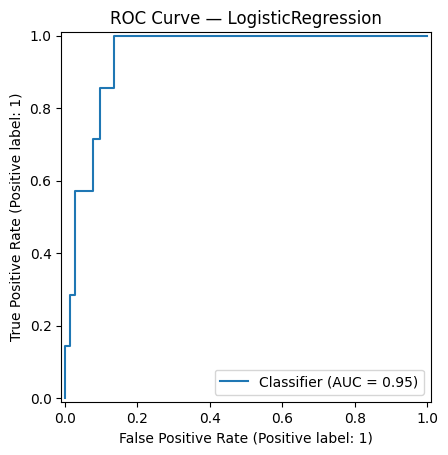

<Figure size 640x480 with 0 Axes>

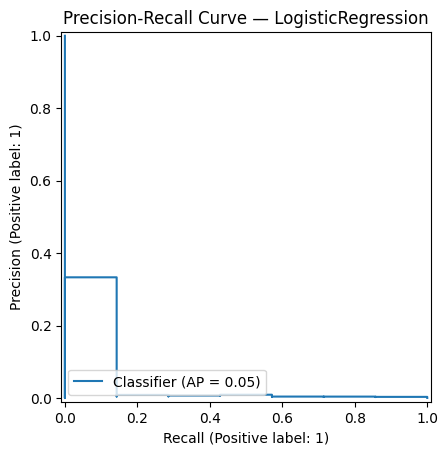

<Figure size 640x480 with 0 Axes>

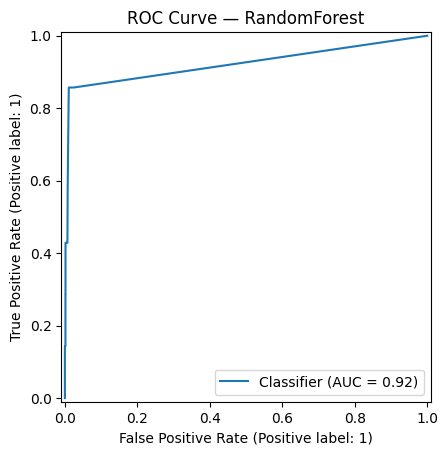

<Figure size 640x480 with 0 Axes>

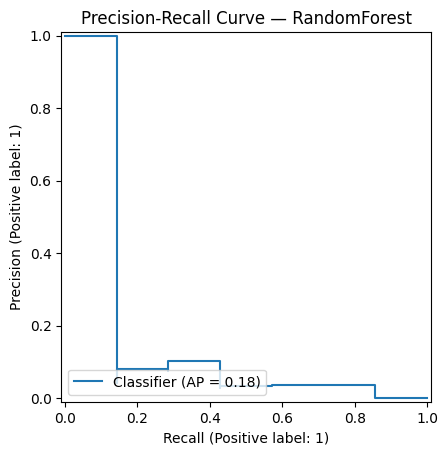

✅ [7] Curvas generadas


In [12]:
# ============================================================
# 7) Entrenamiento + Evaluación completa (correcto para desbalance)
# ============================================================
# Métricas:
# - accuracy: puede engañar si hay desbalance
# - balanced_accuracy: promedia recall de cada clase (mejor con desbalance)
# - precision: de los que predije como incendio, ¿cuántos lo son?
# - recall (sensibilidad): de los incendios reales, ¿cuántos detecté?
# - f1: equilibrio precision/recall
# - roc_auc: calidad de ranking global (puede ser optimista en desbalance fuerte)
# - average_precision (AP) = PR-AUC aproximado:
#   MUY útil con desbalance, porque se centra en la clase positiva
#
# Por qué recall suele ser clave en incendios (visión operativa):
# - Si el modelo "se deja" incendios (bajo recall), fallas en detección temprana.
# - A veces aceptas más falsos positivos (bajar precision) si el objetivo es prevención.
#   (Luego puedes filtrar con reglas operativas, patrullaje, sensores, etc.)
#
# Curvas:
# - ROC: TPR vs FPR
# - Precision-Recall: Precision vs Recall (más informativa si hay pocos positivos)
#
# Elección de mejor modelo:
# - Priorizar recall y AP (PR-AUC)
# - Regla práctica:
#   1) mayor recall
#   2) si empate, mayor average_precision
#   3) si empate, mayor roc_auc
# ============================================================

print("\n🏋️ [7] Configurando modelos con estrategia de desbalance...")

# --- class_weight automático ---
# Para LogisticRegression: class_weight='balanced' ajusta pesos inversamente a frecuencia.
# Para RandomForest: 'balanced' o 'balanced_subsample' suelen ayudar.
lr_class_weight = "balanced" if desbalance_fuerte else None
rf_class_weight = "balanced" if desbalance_fuerte else None

# Actualizamos los modelos dentro de los pipelines
lr_pipeline.set_params(model__class_weight=lr_class_weight)
rf_pipeline.set_params(model__class_weight=rf_class_weight)

print("✅ [7] class_weight LR:", lr_class_weight)
print("✅ [7] class_weight RF:", rf_class_weight)

# --- Construimos pipelines finales (con o sin oversampling) ---
models = {}

if USE_OVERSAMPLING:
    # ImbPipeline aplica sampler SOLO en fit (train). En predict, NO resamplea.
    lr_model = ImbPipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("sampler", sampler),
        ("model", lr_pipeline.named_steps["model"])
    ])
    rf_model = ImbPipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("sampler", sampler),
        ("model", rf_pipeline.named_steps["model"])
    ])
else:
    lr_model = lr_pipeline
    rf_model = rf_pipeline

models["LogisticRegression"] = lr_model
models["RandomForest"] = rf_model

print("✅ [7] Modelos listos:", list(models.keys()))

def _predict_proba_safe(model, X):
    """
    Devuelve probabilidad de clase 1 si el modelo lo soporta.
    Si no, devuelve scores aproximados.
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    # fallback: decision_function -> lo convertimos a pseudo-prob con sigmoide
    if hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        return 1.0 / (1.0 + np.exp(-scores))
    # último recurso: predicción binaria como "prob"
    return model.predict(X).astype(float)

def _evaluate_model(name, model, X_test, y_test):
    """
    Evalúa un modelo y devuelve métricas + objetos útiles.
    """
    proba = _predict_proba_safe(model, X_test)
    y_pred = (proba >= 0.5).astype(int)  # umbral base (luego lo ajustaremos)

    metrics = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "balanced_accuracy": float(balanced_accuracy_score(y_test, y_pred)),
        "precision": float(precision_score(y_test, y_pred, zero_division=0)),
        "recall": float(recall_score(y_test, y_pred, zero_division=0)),
        "f1": float(f1_score(y_test, y_pred, zero_division=0)),
    }

    # roc_auc y average_precision necesitan probabilidades/scores continuos
    try:
        metrics["roc_auc"] = float(roc_auc_score(y_test, proba))
    except Exception:
        metrics["roc_auc"] = None

    try:
        metrics["average_precision"] = float(average_precision_score(y_test, proba))
    except Exception:
        metrics["average_precision"] = None

    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    return metrics, proba, y_pred, cm, report

results = {}

print("\n🚀 [7] Entrenando y evaluando modelos...")
for name, model in models.items():
    print("\n" + "="*70)
    print(f"🏋️ Entrenando: {name}")
    model.fit(X_train, y_train)
    print(f"✅ Entrenamiento OK: {name}")

    metrics, proba, y_pred, cm, report = _evaluate_model(name, model, X_test, y_test)
    results[name] = {
        "model": model,
        "metrics": metrics,
        "proba_test": proba,
        "y_pred_test": y_pred,
        "confusion_matrix": cm,
        "classification_report": report,
    }

    print(f"\n📌 Métricas (test) — {name}")
    for k, v in metrics.items():
        print(f"   - {k:18s}: {v}")

    print("\n🧩 Matriz de confusión (test) [ [TN, FP], [FN, TP] ]:")
    print(cm)

    print("\n🧾 Classification report (test):")
    print(report)

print("\n📈 [7] Dibujando curvas ROC y Precision-Recall (matplotlib)...")

# Curvas en figuras separadas (sin subplots, como pediste)
for name, r in results.items():
    proba = r["proba_test"]

    # ROC
    plt.figure()
    try:
        RocCurveDisplay.from_predictions(y_test, proba)
        plt.title(f"ROC Curve — {name}")
        plt.show()
    except Exception as e:
        print(f"⚠️ No se pudo dibujar ROC para {name}: {str(e)[:200]}")

    # Precision-Recall
    plt.figure()
    try:
        PrecisionRecallDisplay.from_predictions(y_test, proba)
        plt.title(f"Precision-Recall Curve — {name}")
        plt.show()
    except Exception as e:
        print(f"⚠️ No se pudo dibujar PR para {name}: {str(e)[:200]}")

print("✅ [7] Curvas generadas")

In [13]:
# ============================================================
# 7.1) Selección del mejor modelo (criterio explícito para desbalance)
# ============================================================
# Criterio:
# - Principal: recall (queremos capturar el máximo de incendios)
# - Secundario: average_precision (PR-AUC) (muy informativo en desbalance)
# - Tercero: roc_auc (ranking global)
# ============================================================

print("\n🏁 [7.1] Seleccionando mejor modelo (prioriza recall y PR-AUC)...")

def _key_for_selection(m):
    # None-safe
    recall_v = m.get("recall", -1)
    ap_v = m.get("average_precision", -1) if m.get("average_precision") is not None else -1
    roc_v = m.get("roc_auc", -1) if m.get("roc_auc") is not None else -1
    return (recall_v, ap_v, roc_v)

best_name = None
best_key = None

for name, r in results.items():
    key = _key_for_selection(r["metrics"])
    print(f"   - {name}: selection_key (recall, AP, ROC_AUC) = {key}")
    if best_key is None or key > best_key:
        best_key = key
        best_name = name

best_model = results[best_name]["model"]
best_metrics = results[best_name]["metrics"]

print("\n✅ [7.1] Mejor modelo:", best_name)
print("✅ [7.1] Métricas del mejor modelo:", best_metrics)


🏁 [7.1] Seleccionando mejor modelo (prioriza recall y PR-AUC)...
   - LogisticRegression: selection_key (recall, AP, ROC_AUC) = (1.0, 0.05288457756320926, 0.9456581897319963)
   - RandomForest: selection_key (recall, AP, ROC_AUC) = (0.14285714285714285, 0.1839584344161525, 0.9227226250668368)

✅ [7.1] Mejor modelo: LogisticRegression
✅ [7.1] Métricas del mejor modelo: {'accuracy': 0.8464163822525598, 'balanced_accuracy': 0.9231728938209994, 'precision': 0.002982530890498509, 'recall': 1.0, 'f1': 0.00594732370433305, 'roc_auc': 0.9456581897319963, 'average_precision': 0.05288457756320926}



🌲 [8] Importancia de variables (si hay RandomForest)...

🧾 Top features:
                    feature  importance
7          precip_verano_mm    0.292312
1  depresion_rocio_verano_c    0.189227
2                    elev_m    0.106925
9   viento10m_verano_max_ms    0.096158
8             tmax_verano_c    0.068052
0               aspecto_deg    0.066649
3                nbr_verano    0.056677
6             pendiente_deg    0.050490
5               ndwi_verano    0.037272
4               ndvi_verano    0.036237


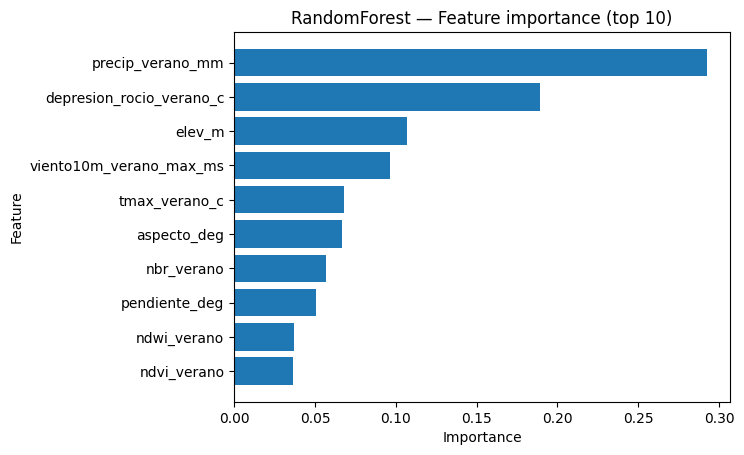

✅ [8] Importancia RF calculada


In [14]:
# ============================================================
# 8) Importancia de variables (RandomForest)
# ============================================================
# Solo aplica si el mejor modelo (o al menos RF) es RandomForest.
#
# ¿Qué significa "importancia" en RF?
# - RF mide cuánto "reduce impureza" cada variable en los splits.
# - Si una variable se usa mucho para separar clases -> suele salir más importante.
#
# Qué NO significa:
# - No significa causalidad ("esta variable causa incendios").
# - No significa que sea estable en el tiempo o en otras regiones.
# - Puede estar sesgada si hay variables correlacionadas.
# ============================================================

print("\n🌲 [8] Importancia de variables (si hay RandomForest)...")

def _plot_feature_importance(importances, feature_names, top_n=10, title="Feature importance (top)"):
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    imp_df = imp_df.sort_values("importance", ascending=False).head(top_n)

    print("\n🧾 Top features:")
    print(imp_df)

    plt.figure()
    plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

    return imp_df

rf_importance_df = None

# Intentamos sacar importancias del modelo RandomForest (aunque no sea el "best")
if "RandomForest" in results:
    rf_model_fitted = results["RandomForest"]["model"]
    # Navegamos para encontrar el estimador final (depende si es Pipeline o ImbPipeline)
    try:
        # Si es pipeline, el último step es "model"
        rf_est = rf_model_fitted.named_steps.get("model", None)
        if rf_est is not None and hasattr(rf_est, "feature_importances_"):
            rf_importance_df = _plot_feature_importance(
                rf_est.feature_importances_,
                numeric_cols,
                top_n=10,
                title="RandomForest — Feature importance (top 10)"
            )
            print("✅ [8] Importancia RF calculada")
        else:
            print("ℹ️ [8] No se encontró feature_importances_ en RandomForest (inesperado).")
    except Exception as e:
        print("⚠️ [8] Error calculando importancias RF:", str(e)[:200])
else:
    print("ℹ️ [8] No se entrenó RandomForest (inesperado).")

In [15]:
# ============================================================
# 9) Guardado de artefactos y resultados (en Drive)
# ============================================================
# ¿Por qué guardamos artefactos?
# - Modelo entrenado (best_model.joblib):
#   para no tener que re-entrenar cada vez
# - metrics.json:
#   para auditar resultados y compararlos con futuros experimentos
# - resumen_ejecutivo.txt:
#   para tener un texto "tipo informe" fácil de compartir
#
# Además:
# - Guardamos un checklist final de archivos guardados.
# ============================================================

print("\n💾 [9] Guardando artefactos en Drive...")

# Rutas de salida
MODEL_PATH = os.path.join(ARTIFACT_DIR, "best_model.joblib")
METRICS_PATH = os.path.join(ARTIFACT_DIR, "metrics.json")
SUMMARY_PATH = os.path.join(ARTIFACT_DIR, "resumen_ejecutivo.txt")

# Metadatos extra para el JSON
metadata = {
    "timestamp": datetime.now().isoformat(),
    "filepath_used": FILEPATH,
    "artifact_dir": ARTIFACT_DIR,
    "random_state": RANDOM_STATE,
    "n_rows_used": int(len(X_full)),
    "n_features": int(len(numeric_cols)),
    "feature_names": numeric_cols,
    "label_name": "fire_label",
    "class_counts": {str(int(k)): int(v) for k, v in class_counts.items()},
    "pos_rate": float(pos_rate),
    "imbalance_ratio_neg_over_pos": float(imbalance_ratio),
    "desbalance_fuerte": bool(desbalance_fuerte),
    "class_weight_lr": lr_class_weight,
    "class_weight_rf": rf_class_weight,
    "oversampling_used": bool(USE_OVERSAMPLING),
    "oversampling_method": sampler_name if USE_OVERSAMPLING else None,
    "train_shape": [int(X_train.shape[0]), int(X_train.shape[1])],
    "test_shape": [int(X_test.shape[0]), int(X_test.shape[1])],
    "best_model_name": best_name,
    "best_model_metrics_test_at_threshold_0.5": best_metrics,
}

# Guardar modelo
joblib.dump(best_model, MODEL_PATH)
print("✅ [9] Modelo guardado:", MODEL_PATH)

# Guardar metrics.json
with open(METRICS_PATH, "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)
print("✅ [9] metrics.json guardado:", METRICS_PATH)

# Resumen ejecutivo (texto)
# Nota: estilo cercano y directo, con foco operativo.
summary_lines = []
summary_lines.append("RESUMEN EJECUTIVO — Predicción de riesgo de incendio (ML)\n")
summary_lines.append(f"- Dataset: {os.path.basename(FILEPATH)}")
summary_lines.append(f"- Filas usadas: {len(X_full):,} | Features: {len(numeric_cols)}")
summary_lines.append(f"- Distribución fire_label: 0={neg:,} | 1={pos:,} | pos_rate={pos_rate*100:.2f}%")
summary_lines.append(f"- Desbalance fuerte: {'Sí' if desbalance_fuerte else 'No'} (ratio neg/pos = {imbalance_ratio:.2f}:1)")
summary_lines.append(f"- Estrategia desbalance:")
summary_lines.append(f"    * class_weight LR: {lr_class_weight}")
summary_lines.append(f"    * class_weight RF: {rf_class_weight}")
summary_lines.append(f"    * oversampling: {'Sí' if USE_OVERSAMPLING else 'No'} ({sampler_name if USE_OVERSAMPLING else 'N/A'})")
summary_lines.append("")
summary_lines.append(f"- Mejor modelo seleccionado: {best_name}")
summary_lines.append(f"- Métricas (test, umbral=0.5):")
for k, v in best_metrics.items():
    summary_lines.append(f"    * {k}: {v}")
summary_lines.append("")
summary_lines.append("Interpretación (muy importante en incendios):")
summary_lines.append("- Recall alto significa que detectas más incendios reales (menos 'se te escapan').")
summary_lines.append("- En datasets desbalanceados, PR-AUC (average_precision) suele ser más informativa que ROC-AUC.")
summary_lines.append("")
summary_lines.append("Siguiente paso recomendado:")
summary_lines.append("- Ajustar umbral de decisión según objetivo operativo (priorizar recall vs falsos positivos).")
summary_lines.append("- Validar en otros años / zonas para comprobar generalización.")
summary_lines.append("")

with open(SUMMARY_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(summary_lines))
print("✅ [9] resumen_ejecutivo.txt guardado:", SUMMARY_PATH)

print("\n📋 [9] Archivos actuales en ARTIFACT_DIR:")
print(os.listdir(ARTIFACT_DIR))


💾 [9] Guardando artefactos en Drive...
✅ [9] Modelo guardado: /content/drive/MyDrive/Piloto-Incendios/03-Artefactos/best_model.joblib
✅ [9] metrics.json guardado: /content/drive/MyDrive/Piloto-Incendios/03-Artefactos/metrics.json
✅ [9] resumen_ejecutivo.txt guardado: /content/drive/MyDrive/Piloto-Incendios/03-Artefactos/resumen_ejecutivo.txt

📋 [9] Archivos actuales en ARTIFACT_DIR:
['best_model.joblib', 'metrics.json', 'resumen_ejecutivo.txt']


# **PREDICCIONES**

In [16]:
# ============================================================
# 10) Predicciones sobre TODO el dataset + export (en Drive)
# ============================================================
# Objetivo:
# - Sacar probabilidad de incendio (0..1) para cada fila del dataset (cada punto/píxel)
# - Exportar:
#   - predictions.csv (lon/lat + prob + pred_clase + fire_label si existe)
#   - predictions.geojson (para QGIS) SIN geopandas (solo json)
#
# Umbral 0.5 y por qué puede ser mala idea:
# ----------------------------------------
# En desbalance, 0.5 suele ser demasiado estricto:
# - El modelo puede dar probabilidades pequeñas incluso a positivos reales
# - Resultado: recall bajo (se te escapan incendios)
#
# BONUS: búsqueda de umbral
# -------------------------
# Buscamos umbral que:
# - maximice F1 (equilibrio) o
# - maximice recall (si lo priorizas) con un mínimo de precisión para no disparar falsos positivos
#
# Export QGIS (pasos simples):
# ----------------------------
# 1) QGIS -> Capa -> Añadir capa -> Añadir capa de texto delimitado -> selecciona predictions.csv
#    - X = lon, Y = lat
#    - CRS = EPSG:4326
# 2) Para GeoJSON: QGIS -> Capa -> Añadir capa vectorial -> selecciona predictions.geojson
# 3) Simbología: colorea por prob_incendio (graduado) y/o filtra pred_clase=1
# ============================================================

print("\n🔮 [10] Generando predicciones sobre TODO el dataset...")

# Preparamos X_all (mismas features, mismo orden)
X_all = df.loc[valid_mask, numeric_cols].apply(pd.to_numeric, errors="coerce").copy()

proba_all = _predict_proba_safe(best_model, X_all)

# --- Ajuste de umbral (BONUS) usando el set de test ---
# Estrategia:
# - Si desbalance fuerte: priorizamos recall (pero evitamos precision=0 total)
# - Si no: maximizamos F1
print("\n🎚️ [10] Ajuste de umbral (usando TEST para calibración)...")

test_proba = results[best_name]["proba_test"]
thresholds = np.linspace(0.01, 0.99, 99)

best_thr = 0.5
best_thr_reason = "default"
best_score = -1

# Parámetro: mínimo de precision aceptable si priorizamos recall
MIN_PRECISION_FOR_RECALL_OPT = 0.05

for thr in thresholds:
    yp = (test_proba >= thr).astype(int)
    prec = precision_score(y_test, yp, zero_division=0)
    rec = recall_score(y_test, yp, zero_division=0)
    f1v = f1_score(y_test, yp, zero_division=0)

    if desbalance_fuerte:
        # Queremos maximizar recall, pero con un mínimo de precision (si no, sería "todo 1" y ya)
        if prec >= MIN_PRECISION_FOR_RECALL_OPT:
            score = rec
            if score > best_score:
                best_score = score
                best_thr = float(thr)
                best_thr_reason = f"max_recall_with_precision>={MIN_PRECISION_FOR_RECALL_OPT}"
    else:
        # Maximizamos F1 si no hay desbalance extremo
        score = f1v
        if score > best_score:
            best_score = score
            best_thr = float(thr)
            best_thr_reason = "max_f1"

print(f"✅ [10] Umbral seleccionado: {best_thr:.2f} ({best_thr_reason}), score={best_score:.4f}")
print("   Nota: esto NO es magia; es una decisión operativa.")
print("   - Si quieres ser muy conservador con falsos positivos, sube el umbral.")
print("   - Si quieres capturar más incendios (recall), baja el umbral.")

pred_class_all = (proba_all >= best_thr).astype(int)

# Construimos dataframe de predicciones
pred_df = df.loc[valid_mask].copy()
pred_df["prob_incendio"] = proba_all
pred_df["pred_clase"] = pred_class_all

# Aseguramos lon/lat existen (si no, ya eran NaN)
if "lon" not in pred_df.columns:
    pred_df["lon"] = np.nan
if "lat" not in pred_df.columns:
    pred_df["lat"] = np.nan

# Guardamos CSV (incluimos columnas útiles)
PRED_CSV_PATH = os.path.join(ARTIFACT_DIR, "predictions.csv")

# Columnas base para export
export_cols = []
for c in ["lon", "lat", "fire_label", "prob_incendio", "pred_clase"]:
    if c in pred_df.columns:
        export_cols.append(c)

# (Opcional) si quieres incluir features, descomenta:
# export_cols += numeric_cols

pred_df_export = pred_df[export_cols].copy()
pred_df_export.to_csv(PRED_CSV_PATH, index=False, encoding="utf-8")
print("✅ [10] predictions.csv guardado:", PRED_CSV_PATH)

# --- Guardamos geojson (opcional recomendado) sin geopandas ---
PRED_GEOJSON_PATH = os.path.join(ARTIFACT_DIR, "predictions.geojson")

print("\n🗺️ [10] Creando predictions.geojson (sin geopandas)...")
features_geojson = []
skipped = 0

# Para no generar GeoJSON gigantesco si hay demasiadas filas:
# - Si tu dataset es enorme (millones), esto puede tardar y pesar mucho.
# - Aquí hacemos un límite opcional por seguridad (puedes cambiarlo).
MAX_GEOJSON_FEATURES = 300000  # ajusta según tamaño real y tu paciencia...

for i, row in pred_df_export.iterrows():
    if len(features_geojson) >= MAX_GEOJSON_FEATURES:
        break

    lon = row.get("lon", np.nan)
    lat = row.get("lat", np.nan)
    if pd.isna(lon) or pd.isna(lat):
        skipped += 1
        continue

    props = {}
    # Guardamos propiedades "ligeras" (no metas todas las features si no hace falta)
    if "fire_label" in row.index:
        props["fire_label"] = int(row["fire_label"]) if not pd.isna(row["fire_label"]) else None
    props["prob_incendio"] = float(row["prob_incendio"])
    props["pred_clase"] = int(row["pred_clase"])

    feat = {
        "type": "Feature",
        "geometry": {"type": "Point", "coordinates": [float(lon), float(lat)]},
        "properties": props
    }
    features_geojson.append(feat)

geojson = {"type": "FeatureCollection", "features": features_geojson}

with open(PRED_GEOJSON_PATH, "w", encoding="utf-8") as f:
    json.dump(geojson, f, ensure_ascii=False)

print("✅ [10] predictions.geojson guardado:", PRED_GEOJSON_PATH)
if skipped > 0:
    print(f"⚠️ [10] Filas sin lon/lat (omitidas del GeoJSON): {skipped:,}")
if len(features_geojson) >= MAX_GEOJSON_FEATURES:
    print(f"⚠️ [10] GeoJSON limitado a {MAX_GEOJSON_FEATURES:,} features para evitar archivos enormes.")
    print("   Si quieres todo, sube MAX_GEOJSON_FEATURES (pero ojo con el peso).")

# --- Actualizamos metrics.json con umbral elegido ---
metadata_update = {
    "chosen_threshold": best_thr,
    "chosen_threshold_reason": best_thr_reason,
    "max_geojson_features": MAX_GEOJSON_FEATURES
}
try:
    with open(METRICS_PATH, "r", encoding="utf-8") as f:
        meta_loaded = json.load(f)
    meta_loaded.update(metadata_update)
    with open(METRICS_PATH, "w", encoding="utf-8") as f:
        json.dump(meta_loaded, f, ensure_ascii=False, indent=2)
    print("✅ [10] metrics.json actualizado con umbral elegido")
except Exception as e:
    print("⚠️ [10] No se pudo actualizar metrics.json:", str(e)[:200])

print("\n📋 [10] Checklist final — Archivos en ARTIFACT_DIR:")
for fn in sorted(os.listdir(ARTIFACT_DIR)):
    print(" -", fn)

print("\n FIN — Pipeline completo ejecutado.")
print("👉 Siguiente paso práctico: abre predictions.csv o predictions.geojson en QGIS y visualiza prob_incendio.")


🔮 [10] Generando predicciones sobre TODO el dataset...

🎚️ [10] Ajuste de umbral (usando TEST para calibración)...
✅ [10] Umbral seleccionado: 0.50 (default), score=-1.0000
   Nota: esto NO es magia; es una decisión operativa.
   - Si quieres ser muy conservador con falsos positivos, sube el umbral.
   - Si quieres capturar más incendios (recall), baja el umbral.
✅ [10] predictions.csv guardado: /content/drive/MyDrive/Piloto-Incendios/03-Artefactos/predictions.csv

🗺️ [10] Creando predictions.geojson (sin geopandas)...
✅ [10] predictions.geojson guardado: /content/drive/MyDrive/Piloto-Incendios/03-Artefactos/predictions.geojson
✅ [10] metrics.json actualizado con umbral elegido

📋 [10] Checklist final — Archivos en ARTIFACT_DIR:
 - best_model.joblib
 - metrics.json
 - predictions.csv
 - predictions.geojson
 - resumen_ejecutivo.txt

🎉 FIN — Pipeline completo ejecutado.
👉 Siguiente paso práctico: abre predictions.csv o predictions.geojson en QGIS y visualiza prob_incendio.
